In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
sql_statement_modelling = """
                        SELECT loc.Country,
                            comp.has_company_logo,
                            post.telecommuting,
                            post.has_questions,
                            post.EmploymentTypeId,
                            post.RequiredExperienceId,
                            post.RequiredEducationId,
                            post.IndustryId,
                            post.functionID,
                            post.fraudulent
                            
                        FROM Posting post INNER JOIN Company comp ON post.CompanyID = comp.CompanyID
                                        INNER JOIN Location loc ON post.LocationID = loc.LocationID
                            """

In [4]:
conn = create_connection("normalized_data.db")
with conn:
    df = pd.read_sql_query(sql_statement_modelling, conn)

In [5]:
df['IndustryID'].nunique()

132

In [6]:
for col in df.columns:
    if df[col].nunique() > 2:
        df[col] = df[col].astype('category')

In [7]:
df = pd.get_dummies(df)

In [8]:
df

,has_company_logo,telecommuting,has_questions,fraudulent,Country_,Country_AE,Country_AL,Country_AM,Country_AR,Country_AT,...,functionID_29,functionID_30,functionID_31,functionID_32,functionID_33,functionID_34,functionID_35,functionID_36,functionID_37,functionID_38
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17876,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X = df.drop('fraudulent', axis=1)
Y = df['fraudulent']

In [10]:
Y.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y)

In [12]:
class_weights = {
    0 : 1 - (Y.value_counts()[0]/(Y.value_counts().sum())),
    1 : 1 - (Y.value_counts()[1]/(Y.value_counts().sum()))
}

In [13]:
weights_array = [class_weights[i] for i in y_train]

In [14]:
forest_model = RandomForestClassifier()
forest_model.fit(x_train, y_train)

RandomForestClassifier()

In [15]:
y_pred = forest_model.predict(x_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4253
           1       0.91      0.56      0.69       217

    accuracy                           0.98      4470
   macro avg       0.94      0.78      0.84      4470
weighted avg       0.97      0.98      0.97      4470



In [17]:
conf_mat = confusion_matrix(y_test, y_pred)

In [18]:
disp = ConfusionMatrixDisplay(conf_mat)

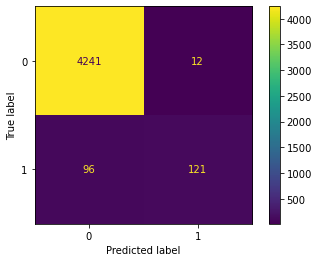

In [19]:
disp.plot()
plt.show()